In [14]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

from openai import OpenAI
from datetime import datetime
from typing import Optional
from dotenv import load_dotenv




load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")
groq_api_key = os.getenv("GROQ_API_KEY")


In [15]:
"""
Taxonomy Generator Module
-------------------------
Uses OpenAI LLM to generate hierarchical taxonomies from dataframe column lists.
Includes JSON export with level information and tree visualization.
"""


class TaxonomyGenerator:
    """
    Generates hierarchical taxonomies from feature lists using OpenAI.
    
    Attributes:
        main_features: Primary features that anchor the taxonomy
        all_features: Complete list of features to organize
        taxonomy: Generated taxonomy structure
    """
    
    def __init__(
        self,
        main_features: list[str],
        all_features: list[str],
        model: str = "gpt-4o",
        api_key: Optional[str] = None
    ):
        """
        Initialize the taxonomy generator.
        
        Args:
            main_features: Primary/anchor features for the taxonomy (Level 1)
            all_features: All features to be organized
            model: OpenAI model name (default: gpt-4o)
            api_key: OpenAI API key (or set via OPENAI_API_KEY env variable)
        """
        self.main_features = main_features
        self.all_features = all_features
        self.model = model
        self.api_key = api_key or os.getenv("OPENAI_API_KEY", "")
        self.taxonomy = None
        self._raw_response = None
        
        # Initialize OpenAI client
        self.client = OpenAI(api_key=self.api_key)
    
    def _build_prompt(self) -> str:
        """Build the prompt for taxonomy generation."""
        prompt = f"""You are an expert in data science and feature engineering. 
Your task is to organize the following features into a hierarchical taxonomy.

MAIN FEATURES (These are the primary categories at Level 1):
{json.dumps(self.main_features, indent=2)}

ALL FEATURES TO ORGANIZE:
{json.dumps(self.all_features, indent=2)}

INSTRUCTIONS:
1. Create a hierarchical taxonomy where the main features form Level 1 categories
2. Organize all other features under appropriate categories
3. Create subcategories (Level 2, Level 3, etc.) where logical groupings exist
4. Consider these grouping patterns:
   - Temporal features (lag, lead, rolling, etc.)
   - Statistical features (mean, std, min, max, etc.)
   - Domain-specific groupings
   - Feature transformations

OUTPUT FORMAT:
Return a valid JSON object with this exact structure:
{{
    "taxonomy_name": "Feature Taxonomy",
    "created_at": "timestamp",
    "levels": {{
        "1": "Main Categories",
        "2": "Subcategories", 
        "3": "Feature Groups",
        "4": "Individual Features"
    }},
    "hierarchy": [
        {{
            "name": "Category Name",
            "level": 1,
            "description": "Brief description",
            "children": [
                {{
                    "name": "Subcategory Name",
                    "level": 2,
                    "description": "Brief description",
                    "children": [...],
                    "features": ["feature1", "feature2"]
                }}
            ],
            "features": ["direct_feature1"]
        }}
    ]
}}

IMPORTANT:
- Every feature from the input list must appear exactly once in the taxonomy
- Use meaningful category names
- Keep the hierarchy logically organized (max 4-5 levels)
- Return ONLY the JSON object, no additional text or markdown formatting
"""
        return prompt
    
    def generate(self) -> dict:
        """
        Generate the taxonomy using OpenAI.
        
        Returns:
            Dictionary containing the hierarchical taxonomy
        """
        prompt = self._build_prompt()
        
        response = self.client.chat.completions.create(
            model=self.model,
            messages=[
                {
                    "role": "system", 
                    "content": "You are a data science expert specializing in feature organization and taxonomy creation. Always respond with valid JSON only."
                },
                {"role": "user", "content": prompt}
            ],
            # temperature=0.3,
            response_format={"type": "json_object"}
        )
        
        self._raw_response = response.choices[0].message.content
        self.taxonomy = self._parse_response(self._raw_response)
        
        # Add metadata if not present
        if "created_at" not in self.taxonomy:
            self.taxonomy["created_at"] = datetime.now().isoformat()
        
        return self.taxonomy
    
    def _parse_response(self, response: str) -> dict:
        """Parse the LLM response into a dictionary."""
        response = response.strip()
        if response.startswith("```"):
            lines = response.split("\n")
            response = "\n".join(lines[1:-1])
        return json.loads(response)
    
    def save_to_json(
        self,
        filepath: str,
        include_metadata: bool = True,
        indent: int = 2
    ) -> str:
        """
        Save the taxonomy to a JSON file.
        
        Args:
            filepath: Path to save the JSON file
            include_metadata: Whether to include generation metadata
            indent: JSON indentation level
            
        Returns:
            Path to the saved file
        """
        if self.taxonomy is None:
            raise ValueError("No taxonomy generated. Call generate() first.")
        
        output = self.taxonomy.copy()
        
        if include_metadata:
            output["_metadata"] = {
                "main_features": self.main_features,
                "total_features": len(self.all_features),
                "model": self.model,
                "generated_at": datetime.now().isoformat()
            }
        
        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(output, f, indent=indent, ensure_ascii=False)
        
        return filepath
    
    def visualize_tree(
        self,
        figsize: tuple = (16, 20),
        save_path: Optional[str] = None,
        show_features: bool = True,
        title: Optional[str] = None
    ) -> plt.Figure:
        """
        Visualize the taxonomy as a hierarchical tree diagram.
        
        Args:
            figsize: Figure size (width, height)
            save_path: Path to save the figure
            show_features: Whether to show leaf features
            title: Custom title
            
        Returns:
            Matplotlib figure object
        """
        if self.taxonomy is None:
            raise ValueError("No taxonomy generated. Call generate() first.")
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # Colors for different levels
        level_colors = {
            1: '#A23B72',  # Level 1 - Magenta
            2: '#F18F01',  # Level 2 - Orange
            3: '#C73E1D',  # Level 3 - Red
            4: '#3B1F2B',  # Level 4 - Dark
        }
        feature_color = '#90BE6D'  # Green for features
        
        # Build flat list of nodes with positions
        nodes = []
        y_position = 0
        
        def add_nodes(node, depth, parent_y=None):
            nonlocal y_position
            
            current_y = y_position
            y_position -= 1
            
            nodes.append({
                'name': node['name'],
                'level': node['level'],
                'depth': depth,
                'y': current_y,
                'parent_y': parent_y,
                'is_feature': False,
                'description': node.get('description', '')
            })
            
            node_y = current_y
            
            # Add children
            for child in node.get('children', []):
                add_nodes(child, depth + 1, node_y)
            
            # Add features
            if show_features:
                for feature in node.get('features', []):
                    y_position -= 0.6
                    nodes.append({
                        'name': feature,
                        'level': node['level'] + 1,
                        'depth': depth + 1,
                        'y': y_position,
                        'parent_y': node_y,
                        'is_feature': True
                    })
        
        # Process hierarchy
        for category in self.taxonomy.get('hierarchy', []):
            add_nodes(category, 0)
            y_position -= 0.8  # Gap between main categories
        
        # Calculate x positions based on depth
        x_scale = 2.5
        
        # Draw connections and nodes
        for node in nodes:
            x = node['depth'] * x_scale
            y = node['y']
            
            # Draw connection to parent (L-shaped connector)
            if node['parent_y'] is not None:
                parent_x = (node['depth'] - 1) * x_scale
                ax.plot([parent_x + 0.15, parent_x + 0.15], [node['parent_y'], y], 
                       color='#888888', linewidth=1, zorder=1)
                ax.plot([parent_x + 0.15, x - 0.1], [y, y], 
                       color='#888888', linewidth=1, zorder=1)
            
            # Node styling
            if node['is_feature']:
                color = feature_color
                fontsize = 8
                fontweight = 'normal'
                marker = 'o'
                marker_size = 40
            else:
                color = level_colors.get(node['level'], '#888888')
                fontsize = 10 if node['level'] == 1 else 9
                fontweight = 'bold'
                marker = 's'  # Square for categories
                marker_size = 80 if node['level'] == 1 else 60
            
            # Draw node
            ax.scatter([x], [y], c=[color], s=marker_size, marker=marker, 
                      zorder=2, edgecolors='white', linewidths=0.5)
            
            # Draw label
            ax.annotate(
                node['name'],
                (x, y),
                xytext=(10, 0),
                textcoords='offset points',
                fontsize=fontsize,
                fontweight=fontweight,
                va='center',
                ha='left',
                color='#333333'
            )
        
        # Create legend
        legend_elements = [
            mpatches.Patch(color=level_colors[1], label='Level 1 (Main Categories)'),
            mpatches.Patch(color=level_colors[2], label='Level 2 (Subcategories)'),
            mpatches.Patch(color=level_colors[3], label='Level 3 (Groups)'),
        ]
        if show_features:
            legend_elements.append(mpatches.Patch(color=feature_color, label='Features'))
        
        ax.legend(handles=legend_elements, loc='upper right', fontsize=9, 
                 framealpha=0.9, edgecolor='#cccccc')
        
        # Set title
        plot_title = title or self.taxonomy.get('taxonomy_name', 'Feature Taxonomy')
        ax.set_title(plot_title, fontsize=14, fontweight='bold', pad=20)
        
        # Clean up axes
        max_depth = max(n['depth'] for n in nodes) if nodes else 0
        ax.set_xlim(-0.5, max_depth * x_scale + 8)
        ax.set_ylim(min(n['y'] for n in nodes) - 1, max(n['y'] for n in nodes) + 1)
        ax.axis('off')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
        
        return fig
    
    def print_tree(self, show_descriptions: bool = False) -> str:
        """
        Print the taxonomy as a text-based tree.
        
        Args:
            show_descriptions: Include descriptions in output
            
        Returns:
            String representation of the tree
        """
        if self.taxonomy is None:
            raise ValueError("No taxonomy generated. Call generate() first.")
        
        lines = []
        lines.append(f"\n{'═' * 60}")
        lines.append(f"  {self.taxonomy.get('taxonomy_name', 'Feature Taxonomy')}")
        lines.append(f"{'═' * 60}\n")
        
        def print_node(node, prefix="", is_last=True):
            # Connector symbols
            connector = "└── " if is_last else "├── "
            
            # Level indicator
            level_marker = f"[L{node['level']}]"
            
            line = f"{prefix}{connector}{level_marker} {node['name']}"
            lines.append(line)
            
            if show_descriptions and node.get('description'):
                desc_prefix = prefix + ("    " if is_last else "│   ")
                lines.append(f"{desc_prefix}    → {node['description']}")
            
            # New prefix for children
            new_prefix = prefix + ("    " if is_last else "│   ")
            
            # Get all children (both child nodes and features)
            children = node.get('children', [])
            features = node.get('features', [])
            
            # Print child nodes
            for i, child in enumerate(children):
                is_last_child = (i == len(children) - 1) and (len(features) == 0)
                print_node(child, new_prefix, is_last_child)
            
            # Print features
            for i, feature in enumerate(features):
                is_last_feature = (i == len(features) - 1)
                feat_connector = "└── " if is_last_feature else "├── "
                lines.append(f"{new_prefix}{feat_connector}● {feature}")
        
        # Process each top-level category
        hierarchy = self.taxonomy.get('hierarchy', [])
        for i, category in enumerate(hierarchy):
            is_last = (i == len(hierarchy) - 1)
            print_node(category, "", is_last)
            if not is_last:
                lines.append("")  # Add spacing between main categories
        
        result = "\n".join(lines)
        print(result)
        return result
    
    def get_features_by_level(self, level: int) -> list[str]:
        """Get all features at a specific level."""
        features = []
        
        def collect(node):
            if node['level'] == level:
                features.extend(node.get('features', []))
            for child in node.get('children', []):
                collect(child)
        
        for category in self.taxonomy.get('hierarchy', []):
            collect(category)
        
        return features
    
    def get_category_path(self, feature_name: str) -> list[str]:
        """Get the hierarchical path to a specific feature."""
        def find_path(node, path):
            current_path = path + [node['name']]
            
            if feature_name in node.get('features', []):
                return current_path
            
            for child in node.get('children', []):
                result = find_path(child, current_path)
                if result:
                    return result
            
            return None
        
        for category in self.taxonomy.get('hierarchy', []):
            path = find_path(category, [])
            if path:
                return path
        
        return []


# Convenience function
def generate_taxonomy(
    main_features: list[str],
    all_features: list[str],
    output_path: str = "taxonomy.json",
    visualize: bool = True,
    viz_path: Optional[str] = None,
    model: str = "gpt-4o",
    api_key: Optional[str] = None
) -> dict:
    """
    Quick function to generate, save, and visualize a taxonomy.
    
    Args:
        main_features: Primary features for Level 1
        all_features: All features to organize
        output_path: Path for JSON output
        visualize: Whether to create visualization
        viz_path: Path for visualization image
        model: OpenAI model name
        api_key: OpenAI API key (optional)
        
    Returns:
        Generated taxonomy dictionary
    """
    generator = TaxonomyGenerator(
        main_features=main_features,
        all_features=all_features,
        model=model,
        api_key=api_key
    )
    
    # Generate taxonomy
    taxonomy = generator.generate()
    
    # Save to JSON
    generator.save_to_json(output_path)
    print(f"✓ Taxonomy saved to: {output_path}")
    
    # Print tree view
    generator.print_tree()
    
    # Create visualization
    if visualize:
        viz_file = viz_path or output_path.replace('.json', '_tree.png')
        generator.visualize_tree(save_path=viz_file)
        print(f"\n✓ Tree visualization saved to: {viz_file}")
    
    return taxonomy


In [16]:
# Load X (features) files
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")

# Load y (target) files
y_train = pd.read_csv("../data/processed/y_train.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Combine X and y for train set
df_train = X_train.copy()
df_train['Sales'] = y_train.values  # Assuming y_train has Sales column or is a single column

# Combine X and y for test set
df_test = X_test.copy()
df_test['Sales'] = y_test.values  # Assuming y_test has Sales column or is a single column

print(f"\ndf_train shape: {df_train.shape}")
print(f"df_test shape: {df_test.shape}")

# Check if Date column exists for temporal ordering
if 'Date' in df_train.columns:
    # Ensure Date is datetime format
    df_train['Date'] = pd.to_datetime(df_train['Date'])
    df_test['Date'] = pd.to_datetime(df_test['Date'])
    
    # Concatenate train and test datasets
    df_combined = pd.concat([df_train, df_test], ignore_index=True)
    
    # Sort by Date to maintain temporal sequence
    df_combined = df_combined.sort_values('Date').reset_index(drop=True)
    
    print(f"\nCombined dataset shape: {df_combined.shape}")
    print(f"Date range: {df_combined['Date'].min()} to {df_combined['Date'].max()}")
else:
    # If no Date column, just concatenate (assuming data is already in order)
    df_combined = pd.concat([df_train, df_test], ignore_index=True)
    print(f"\nCombined dataset shape: {df_combined.shape}")
    print("⚠️  Warning: No Date column found. Temporal order may not be guaranteed.")

print(f"Number of records: {len(df_combined):,}")

# Display first and last few rows to verify
print("\nFirst 3 rows:")
display(df_combined.head(3))
print("\nLast 3 rows:")
display(df_combined.tail(3))

X_train shape: (7831, 199)
X_test shape: (1230, 199)
y_train shape: (7831, 1)
y_test shape: (1230, 1)

df_train shape: (7831, 200)
df_test shape: (1230, 200)

Combined dataset shape: (9061, 200)
Date range: 2023-01-01 00:00:00 to 2023-08-09 00:00:00
Number of records: 9,061

First 3 rows:


,Date,Production,Factory_Issue,Delivery,Rainfall,Sunshine,Humidity,Temperature,typical_rain_mm,BDT_USD,...,category_school_university,category_weather_event,scope_or_location_Chattogram division & south-east,scope_or_location_Nationwide,scope_or_location_Nationwide (strongest in Buddhist communities),scope_or_location_Nationwide (strongest in cities),scope_or_location_Tongi near Dhaka,scope_or_location_Urban centres (esp. Dhaka),scope_or_location_nan,Sales
0,2023-01-01,0.079538,0.049447,0.038181,0.0,0.380952,0.777778,0.222222,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2642.0
1,2023-01-01,0.000000,0.000000,0.000000,0.0,0.380952,0.777778,0.222222,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-01-01,0.000000,0.000000,0.000000,0.0,0.380952,0.777778,0.222222,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0



Last 3 rows:


,Date,Production,Factory_Issue,Delivery,Rainfall,Sunshine,Humidity,Temperature,typical_rain_mm,BDT_USD,...,category_school_university,category_weather_event,scope_or_location_Chattogram division & south-east,scope_or_location_Nationwide,scope_or_location_Nationwide (strongest in Buddhist communities),scope_or_location_Nationwide (strongest in cities),scope_or_location_Tongi near Dhaka,scope_or_location_Urban centres (esp. Dhaka),scope_or_location_nan,Sales
9058,2023-08-09,0.0,0.0,0.0,0.06087,0.438095,0.825397,0.748792,0.0,0.976889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9059,2023-08-09,0.0,0.0,0.0,0.06087,0.438095,0.825397,0.748792,0.0,0.976889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9060,2023-08-09,0.0,0.0,0.0,0.06087,0.438095,0.825397,0.748792,0.0,0.976889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
main_features_df = pd.read_csv("../data/processed/df_merged.csv")
# ls_main_features = main_features_df.drop(columns=["Unnamed: 0", "Date", "Product", "Station", "Sales"]).columns.to_list()


# lag = 1
# lag_df = pd.read_csv(f"../causality/adjacency_matrix_combined_movers_{lag}.csv")

# lag_df_source = lag_df["Source"].unique()
# lag_df_target = lag_df["Target"].unique()

# lag_df_unique_all = list(set(lag_df_source) | set(lag_df_target))




# Remove specified items from lag_df_unique_all if they exist

# items_to_remove = ["Date", "Product", "Station", "Sales"]
items_to_remove = ["Date", "Station"]
ls_all_features = [item for item in df_combined if item not in items_to_remove]

In [ ]:
# main_features_df = pd.read_csv("../data/processed/df_merged.csv")
# ls_main_features = main_features_df.drop(columns=["Unnamed: 0", "Date", "Product", "Station", "Sales"]).columns.to_list()


# lag = 1
# lag_df = pd.read_csv(f"../causality/adjacency_matrix_combined_movers_{lag}.csv")

# lag_df_source = lag_df["Source"].unique()
# lag_df_target = lag_df["Target"].unique()

# lag_df_unique_all = list(set(lag_df_source) | set(lag_df_target))

# # Remove specified items from lag_df_unique_all if they exist
# items_to_remove = ["Date", "Product", "Station", "Sales"]
# ls_all_features = [item for item in lag_df_unique_all if item not in items_to_remove]


════════════════════════════════════════════════════════════
  Feature Taxonomy
════════════════════════════════════════════════════════════

├── [L1] Production
│   ├── [L2] Production - Core Time Series
│   │   ├── ● Production
│   │   ├── ● Production_lag_1
│   │   ├── ● Production_lag_7
│   │   ├── ● Production_lag_14
│   │   ├── ● Production_rolling_mean_1
│   │   ├── ● Production_rolling_std_1
│   │   ├── ● Production_rolling_min_1
│   │   ├── ● Production_rolling_max_1
│   │   ├── ● Production_rolling_mean_7
│   │   ├── ● Production_rolling_std_7
│   │   ├── ● Production_rolling_min_7
│   │   ├── ● Production_rolling_max_7
│   │   ├── ● Production_rolling_mean_14
│   │   ├── ● Production_rolling_std_14
│   │   ├── ● Production_rolling_min_14
│   │   ├── ● Production_rolling_max_14
│   │   └── ● production_sales_ratio
│   ├── [L2] Sales (Demand) Time Series
│   │   ├── ● Sales
│   │   ├── ● Sales_lag_1
│   │   ├── ● Sales_lag_2
│   │   ├── ● Sales_lag_3
│   │   ├── ● Sales_lag_7

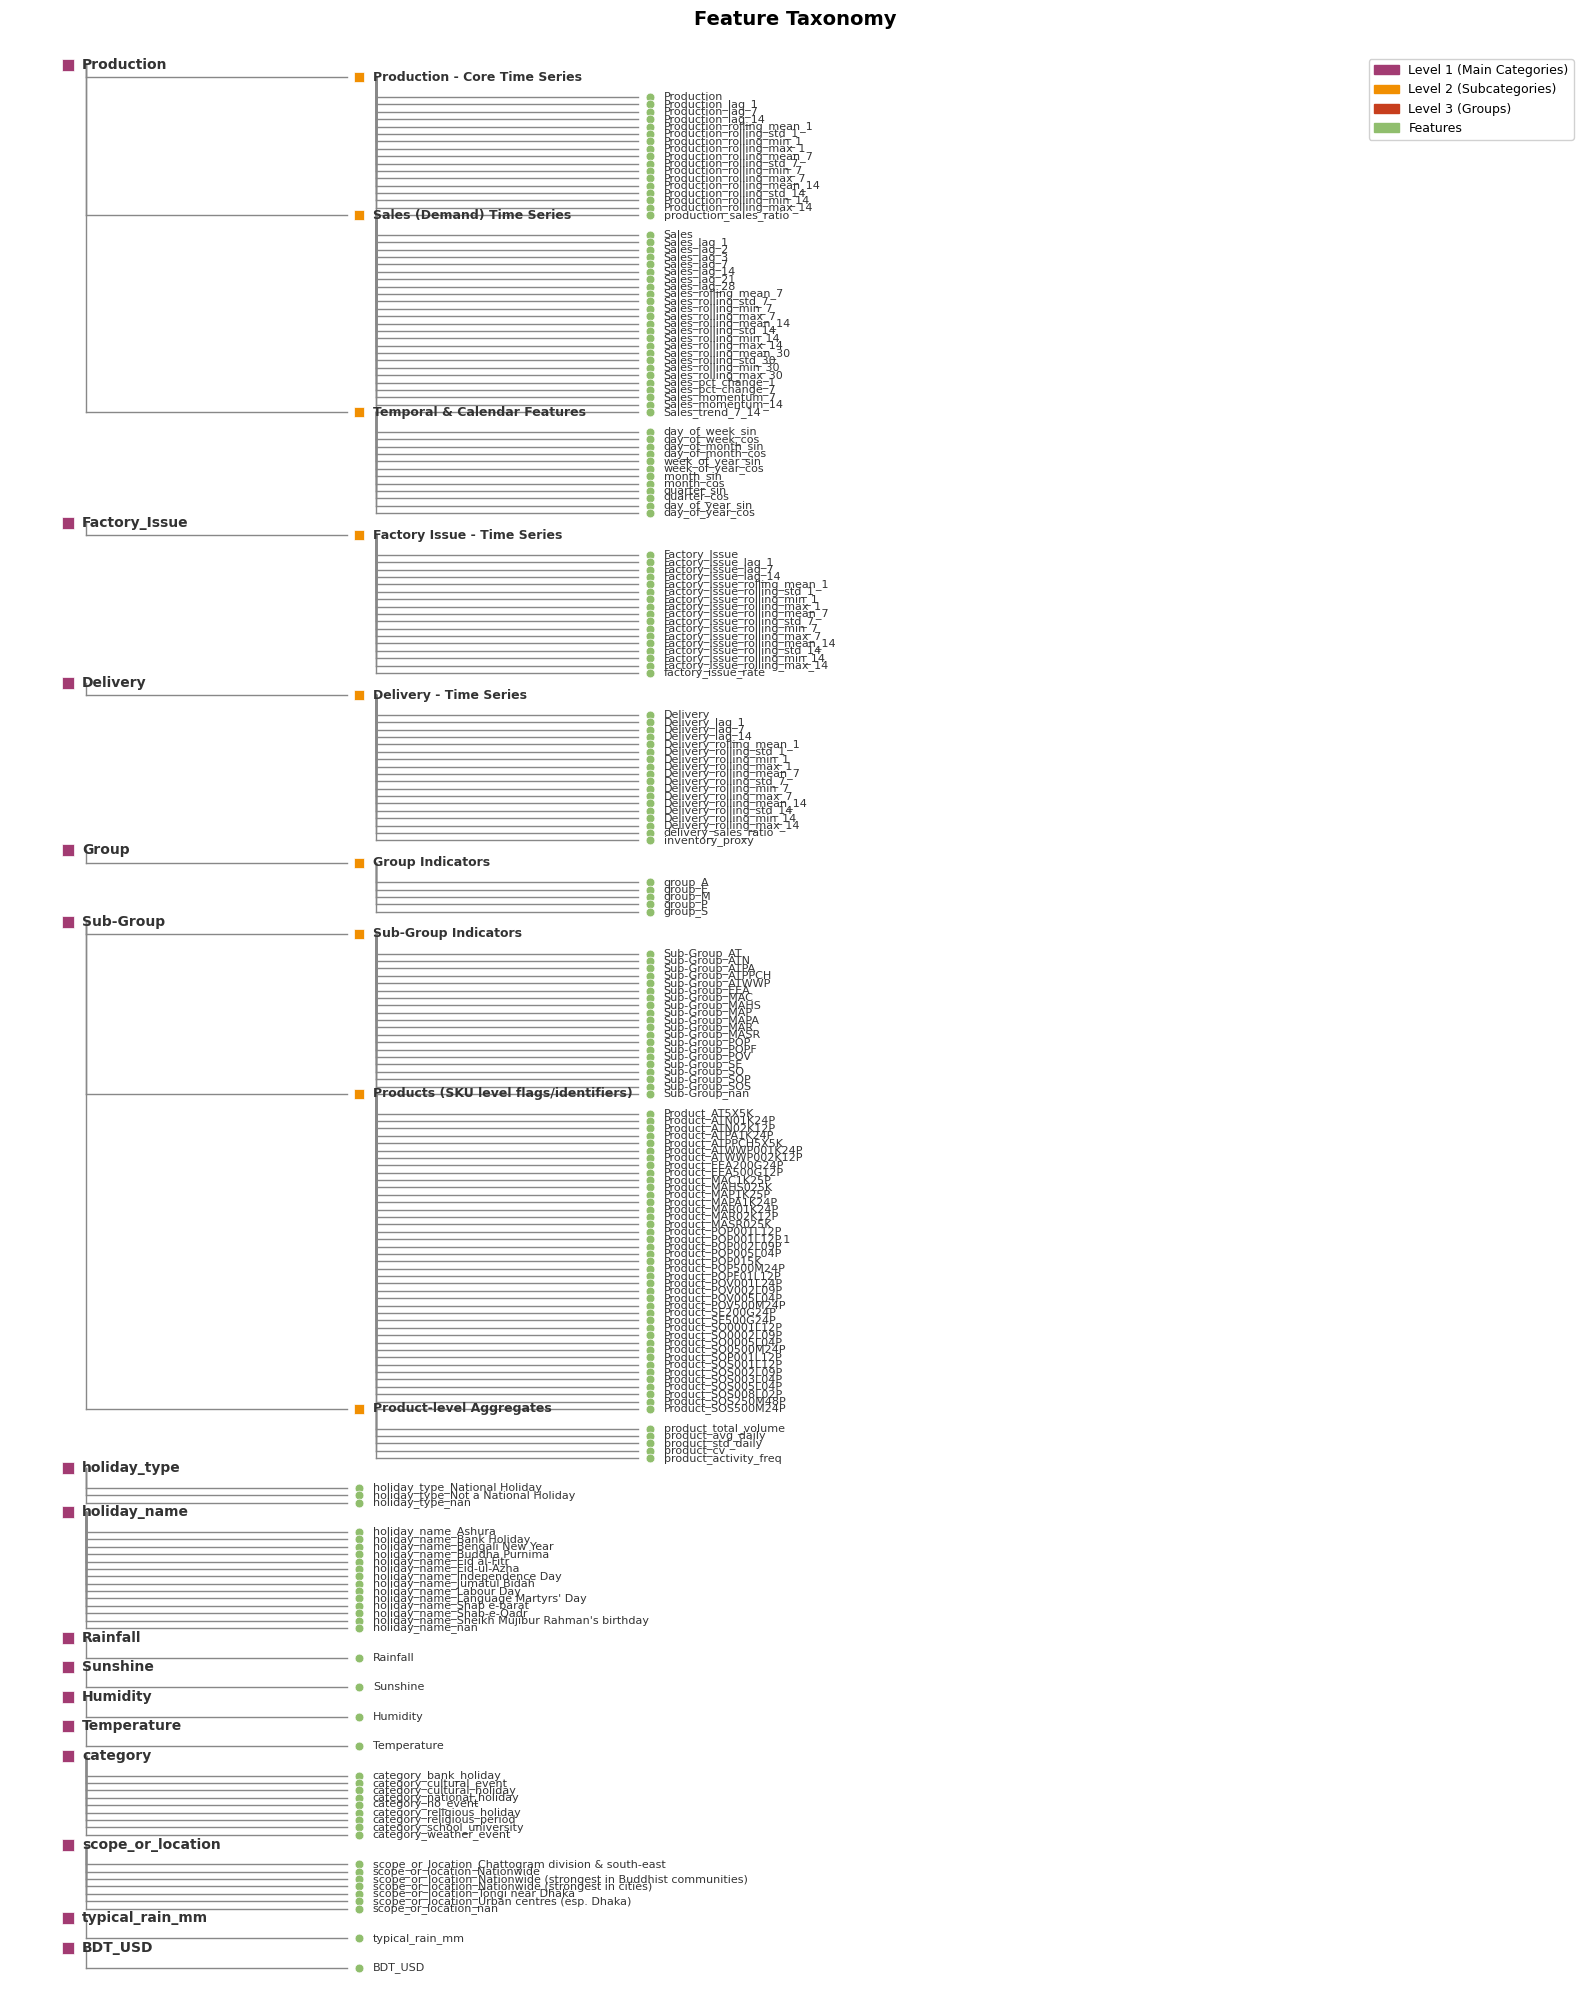

In [18]:
generator = TaxonomyGenerator(
    main_features=ls_main_features,
    all_features=ls_all_features,
    model='gpt-5-mini',
    api_key=openai_api_key  # or set OPENAI_API_KEY env var
)

# Generate taxonomy
taxonomy = generator.generate()

# Print as tree
generator.print_tree()

# Save JSON with level info
generator.save_to_json('../taxonomy/taxonomy_test_2.json')

# Visualize as tree diagram
generator.visualize_tree(save_path='../taxonomy/taxonomy_tree_test_2.png')

# Get path to a feature
path = generator.get_category_path('Temperature_lag_1')
# → ['Environment', 'Temperature', 'Temperature Lags']